# CS 4641 Midterm Checkpoint

In [217]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
# from sklearn.svm import SVC

In [218]:
df = pd.read_csv('data/games.csv')
print(df.shape)

(20058, 16)


---

## Preprocessing

Manual Dimensionality Reduction to remove features that definitely won't be helpful for prediction.

In [219]:
df.drop(['id', 'turns', 'victory_status', 'created_at', 'last_move_at', 'white_id', 'black_id'], axis=1, inplace=True)
df.head()

,rated,winner,increment_code,white_rating,black_rating,moves,opening_eco,opening_name,opening_ply
0,False,white,15+2,1500,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,True,black,5+10,1322,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,True,white,5+10,1496,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,True,white,20+0,1439,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,True,white,30+3,1523,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


**Feature Encoding:** Encode non-numerical features

In [220]:
print(df['increment_code'].nunique())
print(df['opening_eco'].nunique())
print(df['opening_name'].nunique())
print(df['moves'].nunique())

400
365
1477
18920


In [221]:
# If we want just the first part of opening_name:
df['opening_name'] = df['opening_name'].str.split(':').str[0]

# Split moves into list of str in case we want to include any:
df['moves'] = df['moves'].str.split(' ')


In [222]:
print(df['winner'].unique())

print((df['winner'] == 'draw').sum())

# If we want it to be binary classification (slightly more accurate): just drop since its a small number?
# df = df[df['winner'] != 'draw']

['white' 'black' 'draw']
950


In [223]:
# Use label encoder for opening_name, increment_code, opening_eco,  since too many features for one-hot?
le_opening = preprocessing.LabelEncoder()
df['opening_name'] = le_opening.fit_transform(df['opening_name'])
le_winner = preprocessing.LabelEncoder()
df['winner'] = le_winner.fit_transform(df['winner'])
# le_victory = preprocessing.LabelEncoder()
# df['victory_status'] = le_victory.fit_transform(df['victory_status'])
le_eco = preprocessing.LabelEncoder()
df['opening_eco'] = le_eco.fit_transform(df['opening_eco'])
le_increment = preprocessing.LabelEncoder()
df['increment_code'] = le_increment.fit_transform(df['increment_code'])

# For now, dropping moves so I can see if things work
#   Idea: determine frequency of each value in opening_ply, then if one value is very common just use the first x moves for each entry.
#       Or just find the max value in opening_ply, so each one is kept.
#       One new column for each move, then encode them with labelencoder.
df.drop(['moves'], axis=1, inplace=True)

df.head()

,rated,winner,increment_code,white_rating,black_rating,opening_eco,opening_name,opening_ply
0,False,2,110,1500,1191,248,204,5
1,True,0,298,1322,1261,71,147,4
2,True,2,298,1496,1500,171,130,3
3,True,2,187,1439,1454,241,183,3
4,True,2,247,1523,1469,192,162,5


**Dimensionality Reduction with PCA:**

In [ ]:
# To Do: apply PCA to the current dataset. Store PCA-reduced df separately so we can compare how both perform?

---

## Machine Learning Model

In [224]:
X = df.drop('winner', axis=1)
y = df['winner']

In [225]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Cross Validation:** Perform K-Fold cross validation to verify the generalizability of the predictions.

In [226]:
model = RandomForestClassifier()

kfolds = KFold(n_splits=10)
scores = cross_val_score(model, X_train, y_train, cv=kfolds)
print("Accuracy at each fold: " + str(scores))
print("Mean Accuracy: " + str(scores.mean()))

Accuracy at each fold: [0.63239875 0.61993769 0.62866044 0.64423676 0.62367601 0.60934579
 0.6446384  0.65274314 0.61720698 0.62281796]
Mean Accuracy: 0.6295661935503919


Fit a Random Forest Classifier without specifying hyperparameters:

In [227]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

Find and use best hyperparameters using Grid Search:

In [228]:
# To Do (Maybe)
# Reference: https://dev.to/anurag629/gridsearchcv-in-scikit-learn-a-comprehensive-guide-2a72 
# (Except need to use hyperparameters from Random Forest: n_estimators, max_depth, max_features, min_samples_split, min_samples_leaf, maybe others...)

## Evaluation Metrics:

In [229]:
train_accuracy = clf.score(X_train, y_train)
print("Train Score:" + str(train_accuracy))
test_accuracy = clf.score(X_test, y_test)
print("Test Score:" + str(test_accuracy))

y_pred = clf.predict(X_test)

Train Score:0.9991898292409324
Test Score:0.6268693918245264


**Confusion Matrix:** 

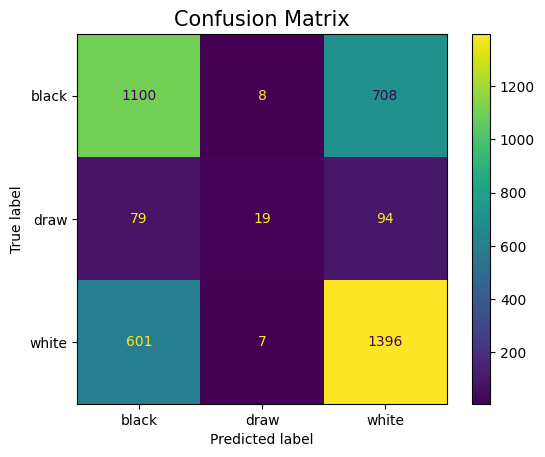

In [230]:
matrix = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['black', 'draw', 'white'])
display.plot()
plt.title('Confusion Matrix', fontsize=15)
plt.show()